In [ ]:
!pip -q install pyvi

     |████████████████████████████████| 8.5 MB 21.2 MB/s 
     |████████████████████████████████| 965 kB 50.1 MB/s 


In [ ]:
from pyvi import ViTokenizer

In [ ]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

Saving kaggle.json to kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d shadabhussain/flickr8k

100% 2.13G/2.13G [01:41<00:00, 21.8MB/s]
100% 2.13G/2.13G [01:41<00:00, 22.6MB/s]


In [ ]:
!unzip /content/flickr8k.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: flickr_data/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848266893_9693c66275.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848571082_26454cb981.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848977044_446a31d86e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2849194983_2968c72832.jpg  
  inflating: flickr_data/Flickr_Data/Images/2850719435_221f15e951.jpg  
  infla

In [ ]:
import progressbar
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, InputLayer \
, Dense, Embedding, LSTM, Dropout, Concatenate, RepeatVector, TimeDistributed, Activation
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import sys
import time
import os
import warnings 
import numpy as np
from numpy import array
import pandas as pd 
import glob 
import pickle
warnings.filterwarnings("ignore")

In [ ]:
dir_Flickr_text = "/content/drive/MyDrive/DL/IMGCAP/ImageCaption/data/Flickr8k.token_VN.txt"
dir_Flickr_jpg_train = "/content/drive/MyDrive/DL/IMGCAP/ImageCaption/data/Flickr_8k.trainImages.txt.txt"
dir_Flickr_jpg_test = "/content/drive/MyDrive/DL/IMGCAP/ImageCaption/data/Flickr_8k.testImages.txt"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Đọc file các caption
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
doc = load_doc(dir_Flickr_text)
print(doc[:500])

1000268201_693b08cb0e.jpg # 0 Một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu thang theo lối vào.
1000268201_693b08cb0e.jpg # 1 Một cô gái đi vào một tòa nhà bằng gỗ.
1000268201_693b08cb0e.jpg # 2 Một cô bé trèo vào nhà chơi bằng gỗ.
1000268201_693b08cb0e.jpg # 3 Một cô bé leo lên cầu thang đến nhà chơi của mình.
1000268201_693b08cb0e.jpg # 4 Một cô bé mặc váy hồng đi vào cabin gỗ.
1001773457_577c3a7d70.jpg # 0 Một con chó đen và một con chó đốm đang chiến đấu
1001773457_577c3a7d70.jpg # 1 Một


In [ ]:
# Lưu caption dưới dạng key value: id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[3:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8112 


In [ ]:
# Preprocessing English text
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [ ]:
# Preprocessing Vietnamese text
import re
exclude = list(string.punctuation) + list(string.digits)
exclude.pop(exclude.index('_'))
def clean_descriptions_vi(descriptions):
  # prepare translation table for removing punctuation
  for key, desc_list in descriptions.items():
      for i in range(len(desc_list)):
        sent = desc_list[i]
        sent = sent.lower()
        sent = sent.strip()
        sent = re.sub("'", " ", sent)
        sent = re.sub("\s+", " ", sent)
        sent = ''.join([char for char in sent if char not in exclude])
        sent = ViTokenizer.tokenize(sent)
        sent = 'startseq ' + sent + ' endseq'
        desc_list[i] = sent
  return descriptions
# clean descriptions
clean_descriptions_vi(descriptions)

{'1000268201_693b08cb0e': ['startseq một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu_thang theo lối vào endseq',
  'startseq một cô gái đi vào một tòa nhà bằng gỗ endseq',
  'startseq một cô bé trèo vào nhà chơi bằng gỗ endseq',
  'startseq một cô bé leo lên cầu_thang đến nhà chơi của mình endseq',
  'startseq một cô bé mặc váy hồng đi vào cabin gỗ endseq'],
 '1001773457_577c3a7d70': ['startseq một con chó đen và một con chó đốm đang chiến_đấu endseq',
  'startseq một con chó đen và một con chó ba màu đang chơi với nhau trên đường endseq',
  'startseq một con chó đen và một con chó trắng có đốm_nâu đang nhìn chằm_chằm vào nhau trên đường_phố endseq',
  'startseq hai con chó thuộc các giống khác nhau nhìn nhau trên đường endseq',
  'startseq hai con chó trên vỉa_hè di_chuyển về phía nhau endseq'],
 '1002674143_1b742ab4b8': ['startseq một cô bé được phủ sơn ngồi trước cầu_vồng được vẽ bằng tay trong một cái bát endseq',
  'startseq một cô bé đang ngồi trước cầu_vồng lớn được sơn endseq

['startseq một người leo núi đang tạo dáng trước những ngọn núi tuyết endseq',
 'startseq một người leo núi đang đứng trước ngọn núi cầm hai cây gậy đi bộ endseq',
 'startseq một người đàn_ông đứng trước những ngọn núi phủ tuyết endseq',
 'startseq một người đàn_ông có hai cột trượt_tuyết đứng gần đỉnh núi endseq',
 'startseq người đàn_ông đội mũ và áo_khoác màu xanh lá cây khi đứng trước một ngọn núi endseq']

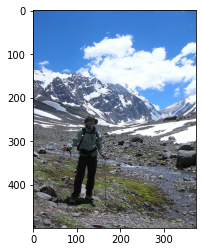

In [ ]:
import matplotlib.pyplot as plt
id = '2098174172_e57d86ea03'
img = plt.imread('/content/Flickr_Data/Flickr_Data/Images/'+id+'.jpg')
plt.imshow(img, cmap='brg')
descriptions[id]

In [ ]:
ViTokenizer.tokenize('một sinh viên đang mua sắm tại siêu thị')

'một sinh_viên đang mua_sắm tại siêu_thị'

In [ ]:
descriptions['1000268201_693b08cb0e']

['startseq một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu_thang theo lối vào endseq',
 'startseq một cô gái đi vào một tòa nhà bằng gỗ endseq',
 'startseq một cô bé trèo vào nhà chơi bằng gỗ endseq',
 'startseq một cô bé leo lên cầu_thang đến nhà chơi của mình endseq',
 'startseq một cô bé mặc váy hồng đi vào cabin gỗ endseq']

In [ ]:
# Lưu description xuống file
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [ ]:
# Lấy id ảnh tương ứng với dữ liệu train, test, dev
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = dir_Flickr_jpg_train
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


# Xử lý image

In [ ]:
# Folder chứa dữ ảnh
images = '/content/Flickr_Data/Flickr_Data/Images/'
# Lấy lấy các ảnh jpg trong thư mục
img = glob.glob(images + '*.jpg')

In [ ]:
# File chứa các id ảnh để train
train_images_file = dir_Flickr_jpg_train
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [ ]:
# File chứa các id ảnh để test
test_images_file = dir_Flickr_jpg_test
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [ ]:
# Lấy description ứng với id của tập train
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = ' '.join(image_desc)
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=5886


In [ ]:
train_descriptions['1000268201_693b08cb0e']

['startseq một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu_thang theo lối vào endseq',
 'startseq một cô gái đi vào một tòa nhà bằng gỗ endseq',
 'startseq một cô bé trèo vào nhà chơi bằng gỗ endseq',
 'startseq một cô bé leo lên cầu_thang đến nhà chơi của mình endseq',
 'startseq một cô bé mặc váy hồng đi vào cabin gỗ endseq']

In [ ]:
def preprocess(image_path):
    # Convert all the images to size image
    img = image.load_img(image_path, target_size=(224, 224))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    return x

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
model = VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))


In [ ]:
for layer in model.layers:
  layer.trainable = False

In [ ]:
modelVGG16 = Model(model.input, model.layers[-2].output)
modelVGG16.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = modelVGG16.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 23ms/step


In [ ]:
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)

1/1 [==============================] - 0s 24ms/step


In [ ]:
with open("/content/drive/MyDrive/DL/IMGCAP/ImageCaption/data/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
with open("/content/drive/MyDrive/DL/IMGCAP/ImageCaption/data/train_descriptions.pkl", "wb") as file:
    pickle.dump(train_descriptions, file)

In [ ]:
with open("/content/drive/MyDrive/DL/IMGCAP/ImageCaption/data/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

==Load

In [ ]:
with open("/content/drive/MyDrive/DL/IMGCAP/ImageCaption/data/encoded_train_images.pkl", "rb") as encoded_pickle:
  encoding_train = pickle.load(encoded_pickle)

In [ ]:
with open("/content/drive/MyDrive/DL/IMGCAP/ImageCaption/data/encoded_test_images.pkl", "rb") as encoded_pickle:
  encoding_test = pickle.load(encoded_pickle)

In [ ]:
encoding_train = pickle.load(open("/content/drive/MyDrive/DL/IMGCAP/ImageCaption/data/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(encoding_train))

Photos: train=6000


# Xử lý caption

In [ ]:
# Tạo list các training caption
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

29399

In [ ]:
'startseq một cô bé mặc váy hồng đi vào cabin gỗ endseq'

'startseq một cô bé mặc váy hồng đi vào cabin gỗ endseq'

In [ ]:
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in ViTokenizer.tokenize(sent).split():
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 4919 -> 2008


In [ ]:
vocab

['startseq',
 'một',
 'đứa',
 'trẻ',
 'mặc',
 'váy',
 'hồng',
 'đang',
 'trèo',
 'lên',
 'bộ',
 'cầu_thang',
 'theo',
 'lối',
 'vào',
 'endseq',
 'cô',
 'gái',
 'đi',
 'tòa',
 'nhà',
 'bằng',
 'gỗ',
 'bé',
 'chơi',
 'leo',
 'đến',
 'của',
 'mình',
 'con',
 'chó',
 'đen',
 'và',
 'đốm',
 'chiến_đấu',
 'ba',
 'màu',
 'với',
 'nhau',
 'trên',
 'đường',
 'trắng',
 'có',
 'đốm_nâu',
 'nhìn',
 'chằm_chằm',
 'đường_phố',
 'hai',
 'thuộc',
 'các',
 'giống',
 'khác',
 'vỉa_hè',
 'di_chuyển',
 'về',
 'phía',
 'được',
 'phủ',
 'sơn',
 'ngồi',
 'trước',
 'cầu_vồng',
 'vẽ',
 'tay',
 'trong',
 'cái',
 'bát',
 'lớn',
 'nhỏ',
 'cỏ',
 'ngón',
 'tấm',
 'vải',
 'đó',
 'bím',
 'tóc',
 'bức',
 'tranh',
 'ngoài',
 'người',
 'đàn_ông',
 'nằm',
 'băng',
 'ghế',
 'khi',
 'anh',
 'ta',
 'cạnh',
 'mà',
 'cũng',
 'bị',
 'trói',
 'ngủ',
 'bên',
 'không',
 'áo',
 'đá',
 'công_viên',
 'giữ',
 'dây_xích',
 'mặt_đất',
 'đội',
 'mũ',
 'cam',
 'thứ',
 'gì',
 'đeo',
 'kính',
 'đồng_hồ',
 'bia',
 'có_thể',
 'móc',
 'mũ_en

In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1  # Thêm 1 cho từ dùng để padding
vocab_size

2009

In [ ]:
import pickle
with open('/content/drive/MyDrive/DL/IMGCAP/ImageCaption/wordtoix.pkl','wb') as f:
  pickle.dump(wordtoix,f)
with open('/content/drive/MyDrive/DL/IMGCAP/ImageCaption/ixtoword.pkl','wb') as f:
  pickle.dump(ixtoword,f)

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 44


In [ ]:
import gensim.models.keyedvectors as word2vec

In [ ]:
!wget https://thiaisotajppub.s3-ap-northeast-1.amazonaws.com/publicfiles/baomoi.window2.vn.model.bin.gz

--2022-11-17 15:03:17--  https://thiaisotajppub.s3-ap-northeast-1.amazonaws.com/publicfiles/baomoi.window2.vn.model.bin.gz
Resolving thiaisotajppub.s3-ap-northeast-1.amazonaws.com (thiaisotajppub.s3-ap-northeast-1.amazonaws.com)... 52.219.196.14, 52.219.137.26, 52.219.137.42, ...
Connecting to thiaisotajppub.s3-ap-northeast-1.amazonaws.com (thiaisotajppub.s3-ap-northeast-1.amazonaws.com)|52.219.196.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494402382 (471M) [application/x-gzip]
Saving to: ‘baomoi.window2.vn.model.bin.gz.1’

baomoi.window2.vn.m 100%[===================>] 471.50M  36.1MB/s    in 14s     

2022-11-17 15:03:32 (33.4 MB/s) - ‘baomoi.window2.vn.model.bin.gz.1’ saved [494402382/494402382]



In [ ]:
!gunzip '/content/baomoi.window2.vn.model.bin.gz'

gzip: /content/baomoi.window2.vn.model.bin already exists; do you wish to overwrite (y or n)? ^C


In [ ]:
glove_vectors = word2vec.KeyedVectors.load_word2vec_format('/content/baomoi.window2.vn.model.bin',  binary=True, unicode_errors='ignore')

In [ ]:
glove_vectors['siêu_thị']

array([-8.42353702e-01,  1.06828749e+00, -1.42867148e-01,  1.46899211e+00,
        1.85591087e-01, -1.01271057e+00,  3.53938043e-01,  1.57726979e+00,
        8.66472125e-01, -4.41791981e-01,  1.61646044e+00,  8.08860302e-01,
       -7.50084639e-01,  1.36168587e+00,  1.44467807e+00, -2.24720407e+00,
       -2.32831612e-01, -1.54919136e+00, -5.45268893e-01,  2.46612325e-01,
       -1.45467353e+00, -1.24978793e+00, -1.00494421e+00, -1.37364125e+00,
       -1.39301097e+00,  6.71969533e-01,  1.31343111e-01, -2.23979068e+00,
       -2.32833758e-01, -9.92672265e-01,  1.30897820e+00,  1.97175872e+00,
        1.03515613e+00, -9.09734726e-01,  4.74634081e-01, -5.54052353e-01,
       -2.71695673e-01, -1.26349175e+00, -1.18774705e-01,  1.49737024e+00,
       -1.51197374e+00, -6.15270972e-01,  7.85810530e-01,  2.44546890e+00,
        3.87166351e-01,  9.70676601e-01,  5.13891160e-01,  1.80144012e-01,
        9.01107490e-01, -1.00141919e+00,  3.34789783e-01, -7.13111222e-01,
       -1.10512245e+00,  

In [ ]:
# embeddings_index = {} # empty dictionary
# for line in glove_vectors:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# glove_vectors.close()
# print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
embedding_dim = 300
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
embedding_vector = None
for word, i in wordtoix.items():
    #if i < max_words:
    try:
      embedding_vector = glove_vectors[word]
    except:
        pass
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
# data generator cho việc train theo từng batch model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield (array(X1), array(X2)), array(y)
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
'startseq một cô bé mặc váy hồng đi vào cabin gỗ endseq'

'startseq một cô bé mặc váy hồng đi vào cabin gỗ endseq'

In [ ]:
'startseq một <pad> *44'

'startseq một <pad> *44'

In [ ]:
with open('/content/drive/MyDrive/DL/IMGCAP/ImageCaption/embedding_matrix.pkl','wb') as f:
  pickle.dump(embedding_matrix,f)

# Xây dựng mô hình

In [ ]:
# from tensorflow.keras import layers, models
# ops.reset_default_graph()
# inputs1 = layers.Input(shape=(4096,))
# fe1 = layers.Dropout(0.5)(inputs1)
# fe2 = layers.Dense(256, activation='relu')(fe1)

# inputs2 = layers.Input(shape=(max_length,))
# se1 = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
# se2 = layers.Dropout(0.5)(se1)
# se3 = layers.LSTM(256)(se2)
# decoder1 = layers.add([fe2, se3])
# decoder2 = layers.Dense(256, activation='relu')(decoder1)
# outputs = layers.Dense(vocab_size, activation='softmax')(decoder2)
# m = models.Model(inputs=[inputs1, inputs2], outputs=outputs)
# m.summary()

In [ ]:
# model 
inputs1 = Sequential()
inputs1.add(Dense(embedding_dim, input_shape=(4096,), activation='relu')) # vector đặc trưng của ảnh tùy vào Encode bằng Inceptionv3 hay VGG16 sẽ có input_shape tương ứng
inputs1.add(RepeatVector(max_length)) # nhân số lượng đầu vào bằng với độ dài của câu (để mỗi LSTM sẽ đưa vào mỗi tấm ảnh + với chuỗi để dự đoan từ mới)
# inputs1 cho ra (44,200)
inputs2 = Sequential()
inputs2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)) # Embedding từ với shape đầu ra là embedding_dim = 200 
inputs2.add(LSTM(embedding_dim, return_sequences=True)) # cho chuỗi đi qua lớp LSTM để tạo ra vector đặc trưng của từ (mà mỗi từ đều có quan hệ với những từ trước đó)
inputs2.add(TimeDistributed(Dense(embedding_dim))) # chia các vector từ theo thời gian với số Dense = 200
# inputs2 cho ra (44,200)
decoder1 = Concatenate()([inputs1.output, inputs2.output])
# kết hợp hai đầu vào cho ra (44,400)
decoder2 = LSTM(1024, return_sequences=False)(decoder1) # đi qua lớp LSTM để Decode ra từ mới
decoder3 = Dense(vocab_size)(decoder2) # từ mới thuộc 1 từ trong từ điển
out = Activation('softmax')(decoder3) # qua hàm kích hoạt softmax để cho ra xác suất có các từ trong từ điển => từ mới có xác suất cao nhất
m = Model(inputs=[inputs1.input, inputs2.input], outputs = out)
m.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_5_input (InputLayer)  [(None, 44)]        0           []                               
                                                                                                  
 dense_15_input (InputLayer)    [(None, 4096)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 44, 300)      602700      ['embedding_5_input[0][0]']      
                                                                                                  
 dense_15 (Dense)               (None, 300)          1229100     ['dense_15_input[0][0]']         
                                                                                            

In [ ]:
m.layers[2].set_weights([embedding_matrix])
m.layers[2].trainable = False

In [ ]:
from keras.callbacks import History 
history = History()

In [ ]:
h = History()
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

# Huấn luyện mô hình

In [ ]:
epochs = 30
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, wordtoix, max_length, number_pics_per_bath)
    m.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[h])

981/981 [==============================] - 211s 215ms/step - loss: 1.0044 - accuracy: 0.6991


In [ ]:
m.save('/content/drive/MyDrive/DL/IMGCAP/ImageCaption/model_vgg16_vi(1).h5')

In [ ]:
with open("/content/history.pkl", "wb") as f:
    pickle.dump(history.history,f)

In [ ]:
with open("/content/drive/MyDrive/DL/IMGCAP/ImageCaption/history.pkl", "wb") as f:
    pickle.dump(history.history,f)

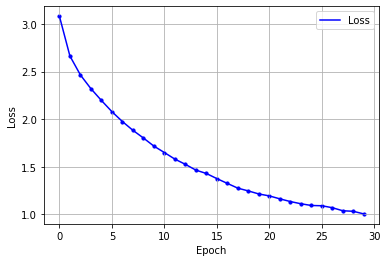

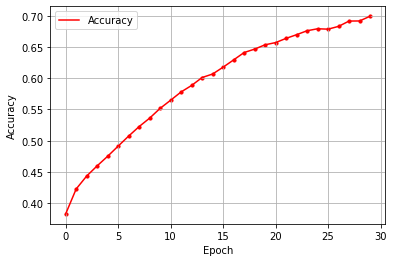

In [ ]:
import matplotlib.pyplot as plt
epoch = np.arange(30)
plt.plot(h.history['loss'], c = 'blue', label = 'Loss')
plt.scatter(epoch,h.history['loss'], c = 'blue', s =10)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

plt.plot(h.history['accuracy'], c = 'red', label = 'Accuracy')
plt.scatter(epoch,h.history['accuracy'], c = 'red', s =10)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

# Đánh giá

In [ ]:
images = '/content/Flickr_Data/Flickr_Data/Images/'

In [ ]:
with open("/content/drive/MyDrive/DL/IMGCAP/ImageCaption/data/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [ ]:
with open("/content/drive/MyDrive/DL/IMGCAP/ImageCaption/data/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = m.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
def score(x, y, num):
  """
  hàm tính điểm bleu cho mô hình
  """
  score = []
  step = 0
  for i in x:
    step +=1
    if(step ==num):
      break
    image = x[i].reshape((1,4096))
    tran = greedySearch(image)
    references = []
    candidate = []
    pre = y[i[:-4]]
    
    candidate.append(tran)
    references.append(pre)
    score1 = corpus_bleu(references, candidate, weights=(0.25, 0.25))
    score.append(score1)
    print(step)
  return np.mean(score)

In [ ]:
test = load_set(dir_Flickr_jpg_test)
test_descriptions = load_clean_descriptions('descriptions.txt', test)

In [ ]:
print('BLEU score:',score(encoding_test, test_descriptions, 50))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
BLEU score: 0.7571243918921592


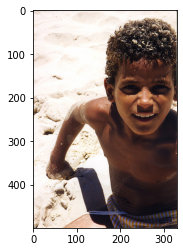

một cô bé với khuôn_mặt được đặt vào mặt một người_lớn  / time: 0.7651193141937256  seconds


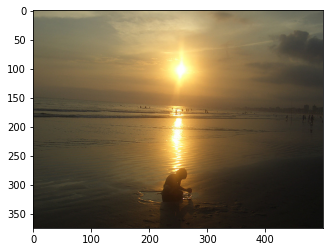

một người đàn_ông và một người phụ_nữ đang đứng trên lan_can ngắm bờ  / time: 0.8586812019348145  seconds


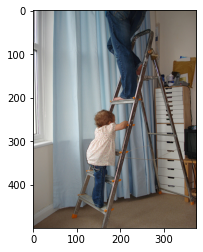

một cậu bé mặc áo sơ_mi trắng và quần_jean xanh nhảy_múa trên sàn nhà  / time: 0.9203972816467285  seconds


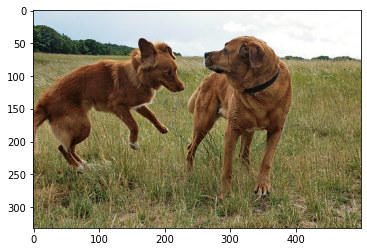

một con chó màu nâu đang cúi xuống và một con chó màu xám trên cỏ  / time: 1.097456693649292  seconds


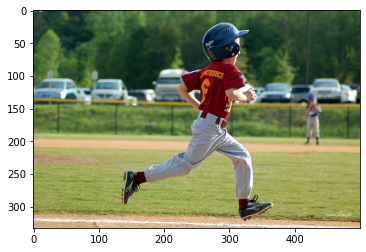

một người đàn_ông mặc đồ trắng và quần short nhảy lên không_trung  / time: 0.8650078773498535  seconds


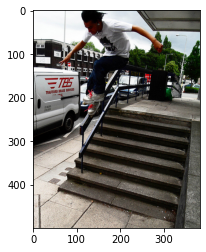

một người đàn_ông đội mũ nâu đang đi ngang qua đường  / time: 0.7940273284912109  seconds


In [ ]:
import time
for z in range(len(encoding_test)):
  start = time.time()
  pic = list(encoding_test.keys())[z+2]
  image = encoding_test[pic].reshape((1,4096))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  print(greedySearch(image), ' / time:', time.time() -start,' seconds')
  if (z ==5):
    break